# 🚁 Prédiction de Renversement de Drone

Ce notebook présente un modèle de Machine Learning (Random Forest) pour prédire si un drone risque de se renverser en fonction des données du gyroscope.

## Labels
- **0** : Stable (pas de risque)
- **1** : Risque modéré (inclinaison élevée)
- **2** : Renversement imminent (danger critique)

## 1. 📦 Importation des Bibliothèques

In [1]:
# Installation des dépendances si nécessaire
# !pip install pandas numpy scikit-learn matplotlib seaborn joblib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
print("✅ Bibliothèques importées avec succès!")

✅ Bibliothèques importées avec succès!


## 2. 📂 Chargement des Données

In [3]:
# Charger le dataset
df = pd.read_csv('../AI (benmchich)/gyro_angles_labeled.csv')

print(f"📊 Dimensions du dataset: {df.shape[0]} lignes, {df.shape[1]} colonnes")
print(f"\n📋 Colonnes: {list(df.columns)}")
df.head(10)

📊 Dimensions du dataset: 19190 lignes, 6 colonnes

📋 Colonnes: ['timestamp', 'angle_x', 'angle_y', 'angle_z', 'max_tilt', 'label']


,timestamp,angle_x,angle_y,angle_z,max_tilt,label
0,55.514925,-0.007327,-0.007377,0.001637,0.007377,0
1,55.585439,0.001708,-0.019853,0.021417,0.019853,0
2,55.666026,-0.001325,-0.013913,0.060491,0.013913,0
3,55.736540,-0.144643,0.031181,0.098260,0.144643,0
4,55.807054,-0.316625,0.133238,0.168970,0.316625,0
5,55.897714,-0.276364,0.162981,0.169413,0.276364,0
6,55.958155,-0.300308,0.143218,0.162534,0.300308,0
7,56.018595,-0.230967,0.104859,0.154962,0.230967,0
8,56.099182,-0.222493,0.162473,0.163565,0.222493,0
9,56.179770,-0.255617,0.188811,0.116754,0.255617,0


In [4]:
# Informations sur le dataset
print("📈 Informations sur les données:")
print("="*50)
df.info()
print("\n📊 Statistiques descriptives:")
df.describe()

📈 Informations sur les données:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19190 entries, 0 to 19189
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  19190 non-null  float64
 1   angle_x    19190 non-null  float64
 2   angle_y    19190 non-null  float64
 3   angle_z    19190 non-null  float64
 4   max_tilt   19190 non-null  float64
 5   label      19190 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 899.7 KB

📊 Statistiques descriptives:


,timestamp,angle_x,angle_y,angle_z,max_tilt,label
count,19190.000000,19190.000000,19190.000000,19190.000000,19190.000000,19190.000000
mean,729.193743,8.451610,-36.279192,13.117951,37.604651,1.809432
std,381.733901,18.227176,10.442089,7.272622,8.328043,0.428424
min,55.514925,-66.489692,-62.166097,-7.576311,0.007377,0.000000
25%,401.455880,-1.569967,-41.280765,8.243323,35.651268,2.000000
50%,733.130160,15.106876,-38.269825,11.511276,38.394177,2.000000
75%,1060.326052,19.345639,-35.289035,17.139000,41.392512,2.000000
max,1383.632901,60.488944,28.268259,47.653844,66.489692,2.000000


In [5]:
# Vérifier les valeurs manquantes
print("🔍 Valeurs manquantes par colonne:")
print(df.isnull().sum())
print(f"\n✅ Total valeurs manquantes: {df.isnull().sum().sum()}")

🔍 Valeurs manquantes par colonne:
timestamp    0
angle_x      0
angle_y      0
angle_z      0
max_tilt     0
label        0
dtype: int64

✅ Total valeurs manquantes: 0


## 3. 📊 Analyse Exploratoire des Données (EDA)

In [6]:
# Distribution des labels
print("🏷️ Distribution des labels:")
label_counts = df['label'].value_counts().sort_index()
print(label_counts)
print(f"\n📊 Pourcentages:")
print((label_counts / len(df) * 100).round(2))

🏷️ Distribution des labels:
label
0      281
1     3095
2    15814
Name: count, dtype: int64

📊 Pourcentages:
label
0     1.46
1    16.13
2    82.41
Name: count, dtype: float64


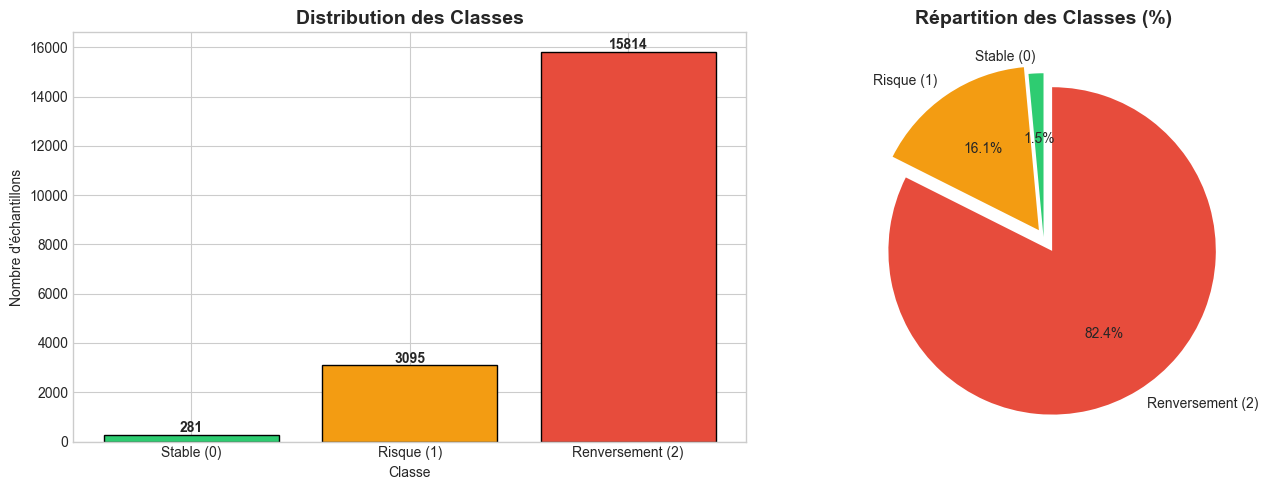

In [7]:
# Visualisation de la distribution des labels
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = ['#2ecc71', '#f39c12', '#e74c3c']
labels_names = ['Stable (0)', 'Risque (1)', 'Renversement (2)']
axes[0].bar(labels_names, label_counts.values, color=colors, edgecolor='black')
axes[0].set_title('Distribution des Classes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Nombre d\'échantillons')
for i, v in enumerate(label_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(label_counts.values, labels=labels_names, colors=colors, autopct='%1.1f%%', 
            startangle=90, explode=(0, 0.05, 0.1))
axes[1].set_title('Répartition des Classes (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

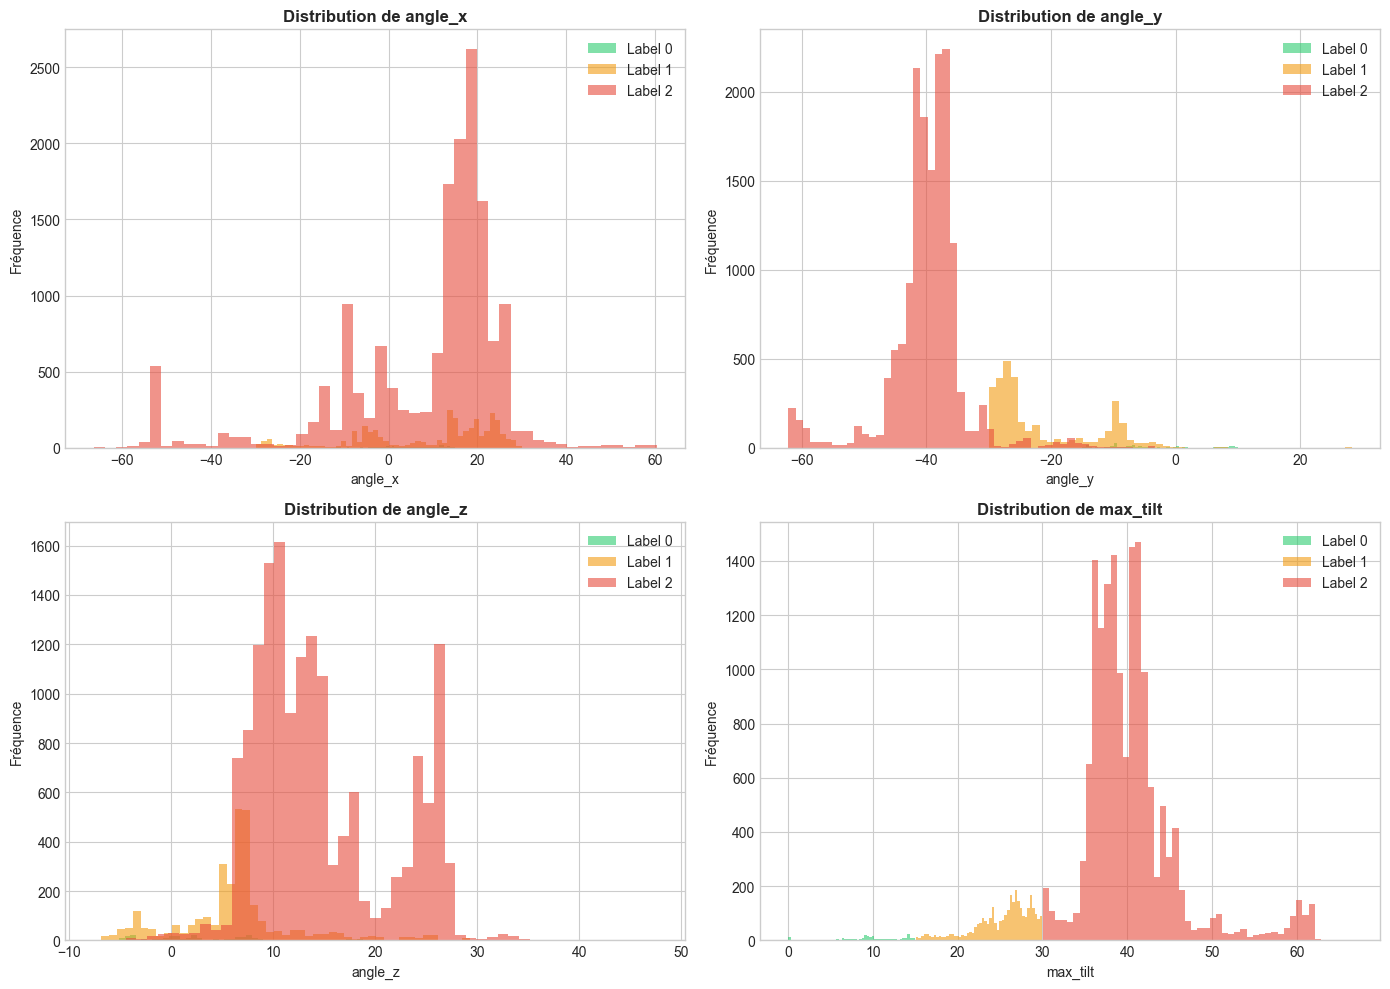

In [8]:
# Distribution des angles par classe
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features = ['angle_x', 'angle_y', 'angle_z', 'max_tilt']
for idx, feature in enumerate(features):
    ax = axes[idx // 2, idx % 2]
    for label in [0, 1, 2]:
        data = df[df['label'] == label][feature]
        ax.hist(data, bins=50, alpha=0.6, label=f'Label {label}', color=colors[label])
    ax.set_title(f'Distribution de {feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel(feature)
    ax.set_ylabel('Fréquence')
    ax.legend()

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

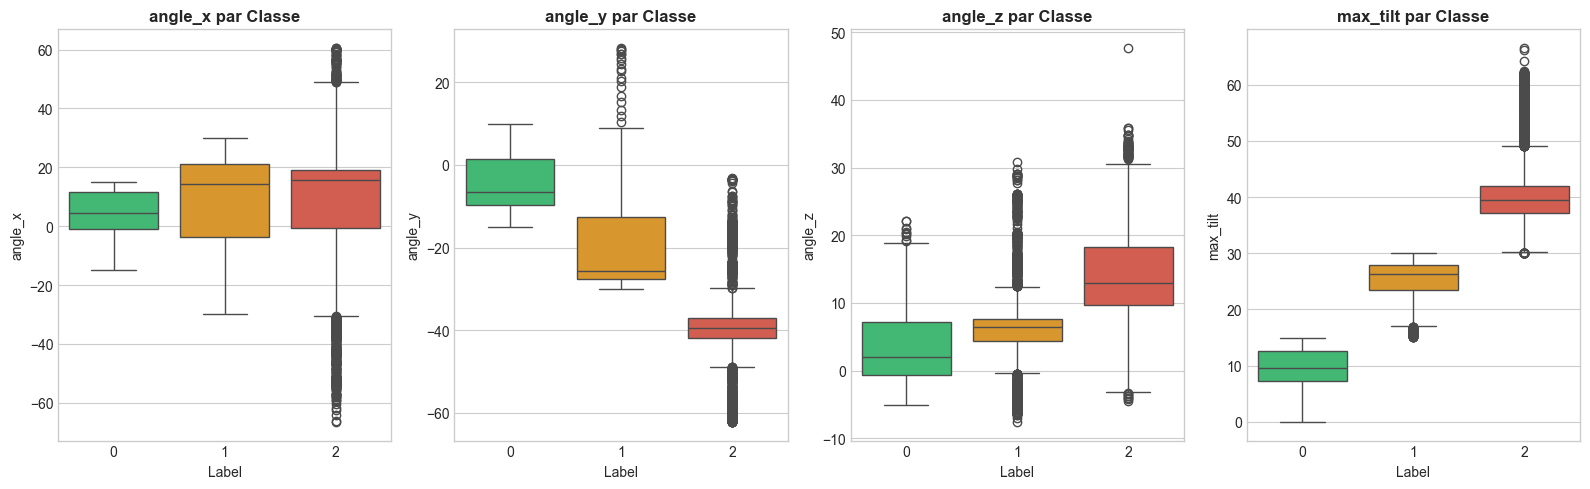

In [9]:
# Boxplots par classe
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for idx, feature in enumerate(features):
    sns.boxplot(data=df, x='label', y=feature, ax=axes[idx], palette=colors)
    axes[idx].set_title(f'{feature} par Classe', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Label')

plt.tight_layout()
plt.savefig('boxplots_by_class.png', dpi=150, bbox_inches='tight')
plt.show()

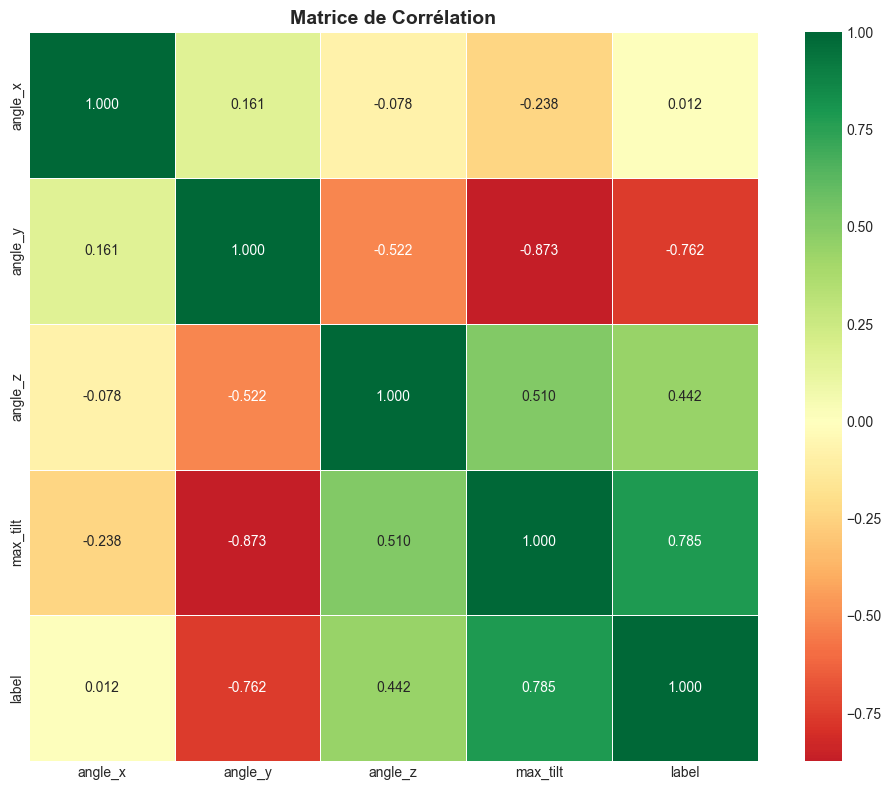

In [10]:
# Matrice de corrélation
plt.figure(figsize=(10, 8))
correlation_matrix = df[features + ['label']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', center=0, 
            fmt='.3f', linewidths=0.5, square=True)
plt.title('Matrice de Corrélation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
# Statistiques par classe
print("📊 Statistiques par classe:")
print("="*60)
for label in [0, 1, 2]:
    print(f"\n🏷️ Label {label}:")
    print(df[df['label'] == label][features].describe().round(2))

📊 Statistiques par classe:

🏷️ Label 0:
       angle_x  angle_y  angle_z  max_tilt
count   281.00   281.00   281.00    281.00
mean      3.97    -4.16     3.34      9.50
std       7.76     7.45     6.31      3.80
min     -14.82   -14.97    -5.08      0.01
25%      -0.88    -9.76    -0.67      7.34
50%       4.55    -6.47     2.04      9.62
75%      11.70     1.44     7.26     12.56
max      14.92    10.03    22.07     14.97

🏷️ Label 1:
       angle_x  angle_y  angle_z  max_tilt
count  3095.00  3095.00  3095.00   3095.00
mean      8.69   -20.98     6.35     25.34
std      15.35     9.02     5.87      3.37
min     -29.91   -29.99    -7.58     15.07
25%      -3.79   -27.51     4.38     23.49
50%      14.25   -25.69     6.50     26.23
75%      21.04   -12.55     7.60     27.84
max      29.96    28.27    30.82     29.99

🏷️ Label 2:
        angle_x   angle_y   angle_z  max_tilt
count  15814.00  15814.00  15814.00  15814.00
mean       8.48    -39.84     14.62     40.50
std       18.86      6

## 4. 🔧 Préparation des Données

In [12]:
# Séparation des features et de la target
X = df[['angle_x', 'angle_y', 'angle_z', 'max_tilt']]
y = df['label']

print(f"📊 Features shape: {X.shape}")
print(f"🎯 Target shape: {y.shape}")
print(f"\n📋 Features utilisées: {list(X.columns)}")

📊 Features shape: (19190, 4)
🎯 Target shape: (19190,)

📋 Features utilisées: ['angle_x', 'angle_y', 'angle_z', 'max_tilt']


In [13]:
# Division train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📚 Ensemble d'entraînement: {X_train.shape[0]} échantillons")
print(f"🧪 Ensemble de test: {X_test.shape[0]} échantillons")
print(f"\n📊 Distribution dans le train set:")
print(y_train.value_counts().sort_index())
print(f"\n📊 Distribution dans le test set:")
print(y_test.value_counts().sort_index())

📚 Ensemble d'entraînement: 15352 échantillons
🧪 Ensemble de test: 3838 échantillons

📊 Distribution dans le train set:
label
0      225
1     2476
2    12651
Name: count, dtype: int64

📊 Distribution dans le test set:
label
0      56
1     619
2    3163
Name: count, dtype: int64


In [14]:
# Normalisation des données (optionnel pour Random Forest, mais utile pour la visualisation)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Données normalisées")
print(f"\nMoyennes après normalisation: {X_train_scaled.mean(axis=0).round(4)}")
print(f"Écarts-types après normalisation: {X_train_scaled.std(axis=0).round(4)}")

✅ Données normalisées

Moyennes après normalisation: [-0.  0. -0.  0.]
Écarts-types après normalisation: [1. 1. 1. 1.]


## 5. 🌲 Entraînement du Modèle Random Forest

In [15]:
# Modèle de base
rf_base = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Entraînement
print("🚀 Entraînement du modèle Random Forest...")
rf_base.fit(X_train, y_train)
print("✅ Modèle entraîné avec succès!")

🚀 Entraînement du modèle Random Forest...
✅ Modèle entraîné avec succès!


In [16]:
# Prédictions
y_pred_base = rf_base.predict(X_test)

# Métriques de base
accuracy_base = accuracy_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base, average='weighted')

print("📊 Résultats du modèle de base:")
print("="*50)
print(f"🎯 Accuracy: {accuracy_base:.4f} ({accuracy_base*100:.2f}%)")
print(f"📈 F1-Score (weighted): {f1_base:.4f}")

📊 Résultats du modèle de base:
🎯 Accuracy: 0.9997 (99.97%)
📈 F1-Score (weighted): 0.9997


In [17]:
# Rapport de classification détaillé
print("\n📋 Rapport de Classification:")
print("="*60)
target_names = ['Stable (0)', 'Risque (1)', 'Renversement (2)']
print(classification_report(y_test, y_pred_base, target_names=target_names))


📋 Rapport de Classification:
                  precision    recall  f1-score   support

      Stable (0)       1.00      1.00      1.00        56
      Risque (1)       1.00      1.00      1.00       619
Renversement (2)       1.00      1.00      1.00      3163

        accuracy                           1.00      3838
       macro avg       1.00      1.00      1.00      3838
    weighted avg       1.00      1.00      1.00      3838



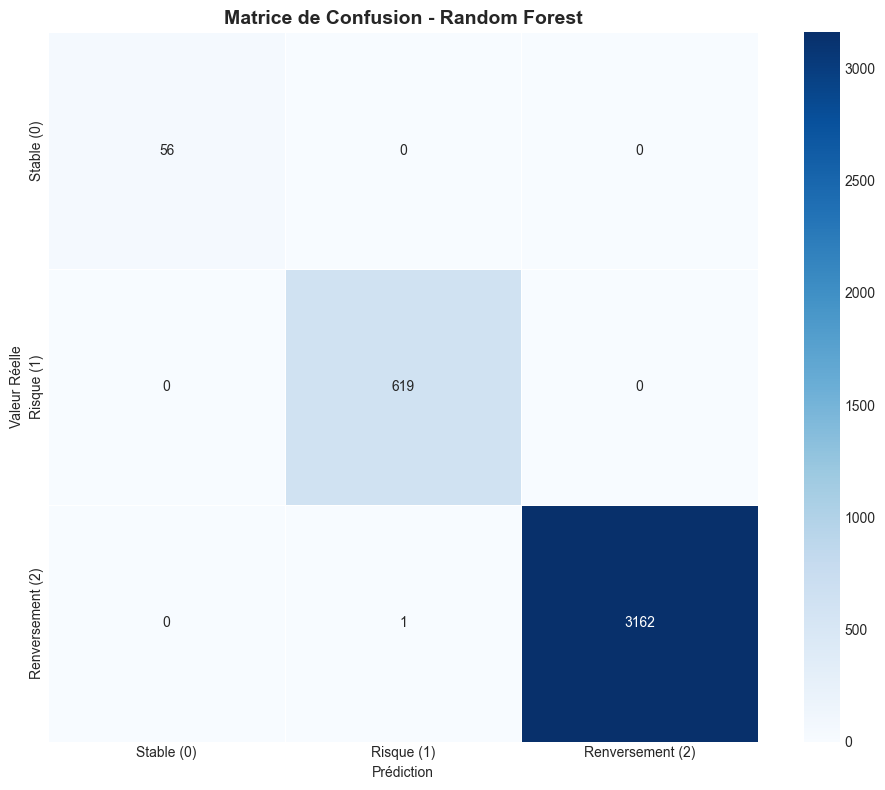

In [18]:
# Matrice de confusion
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names,
            linewidths=0.5, square=True)
plt.title('Matrice de Confusion - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Prédiction')
plt.ylabel('Valeur Réelle')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. 🔍 Optimisation des Hyperparamètres

In [19]:
# Grid Search pour trouver les meilleurs hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("🔍 Recherche des meilleurs hyperparamètres (Grid Search)...")
print("⏳ Cela peut prendre quelques minutes...")

rf_grid = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    rf_grid, param_grid, cv=5, scoring='f1_weighted', 
    n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

print("\n✅ Recherche terminée!")
print(f"\n🏆 Meilleurs paramètres: {grid_search.best_params_}")
print(f"📈 Meilleur score F1 (CV): {grid_search.best_score_:.4f}")

🔍 Recherche des meilleurs hyperparamètres (Grid Search)...
⏳ Cela peut prendre quelques minutes...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Recherche terminée!

🏆 Meilleurs paramètres: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
📈 Meilleur score F1 (CV): 1.0000


In [20]:
# Meilleur modèle
best_rf = grid_search.best_estimator_

# Prédictions avec le meilleur modèle
y_pred_best = best_rf.predict(X_test)

# Métriques
accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print("📊 Résultats du modèle optimisé:")
print("="*50)
print(f"🎯 Accuracy: {accuracy_best:.4f} ({accuracy_best*100:.2f}%)")
print(f"📈 F1-Score (weighted): {f1_best:.4f}")
print(f"\n📈 Amélioration Accuracy: +{(accuracy_best - accuracy_base)*100:.2f}%")
print(f"📈 Amélioration F1-Score: +{(f1_best - f1_base)*100:.2f}%")

📊 Résultats du modèle optimisé:
🎯 Accuracy: 0.9997 (99.97%)
📈 F1-Score (weighted): 0.9997

📈 Amélioration Accuracy: +0.00%
📈 Amélioration F1-Score: +0.00%


In [21]:
# Rapport de classification du meilleur modèle
print("\n📋 Rapport de Classification (Modèle Optimisé):")
print("="*60)
print(classification_report(y_test, y_pred_best, target_names=target_names))


📋 Rapport de Classification (Modèle Optimisé):
                  precision    recall  f1-score   support

      Stable (0)       1.00      1.00      1.00        56
      Risque (1)       1.00      1.00      1.00       619
Renversement (2)       1.00      1.00      1.00      3163

        accuracy                           1.00      3838
       macro avg       1.00      1.00      1.00      3838
    weighted avg       1.00      1.00      1.00      3838



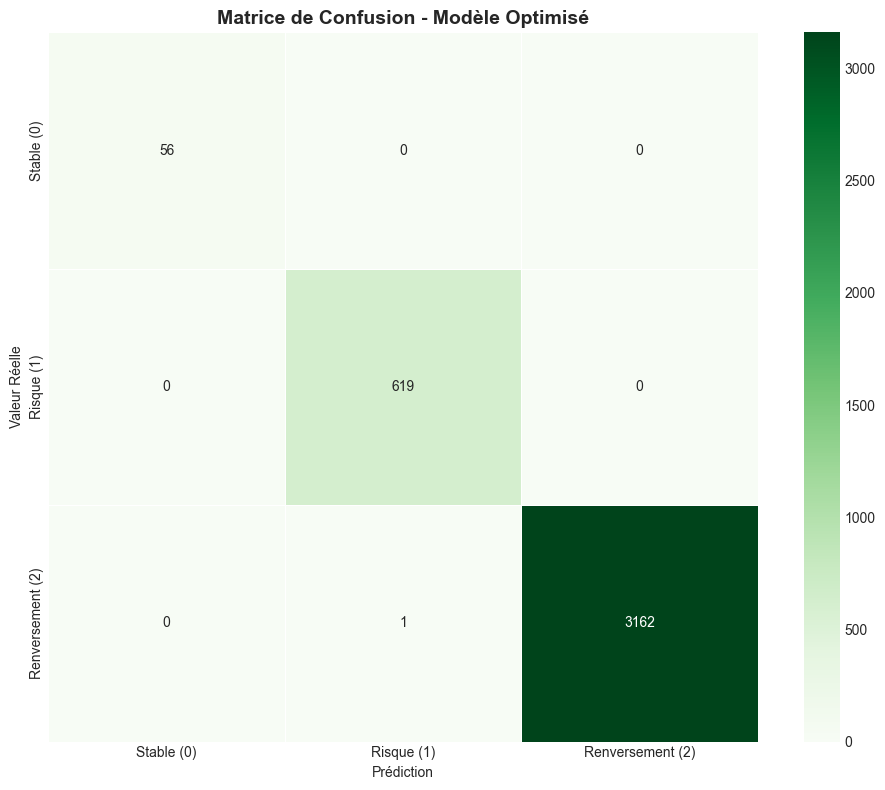

In [22]:
# Matrice de confusion du meilleur modèle
plt.figure(figsize=(10, 8))
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens', 
            xticklabels=target_names, yticklabels=target_names,
            linewidths=0.5, square=True)
plt.title('Matrice de Confusion - Modèle Optimisé', fontsize=14, fontweight='bold')
plt.xlabel('Prédiction')
plt.ylabel('Valeur Réelle')
plt.tight_layout()
plt.savefig('confusion_matrix_optimized.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. 📊 Importance des Features

📊 Importance des Features:
    Feature  Importance
3  max_tilt    0.577593
1   angle_y    0.328415
2   angle_z    0.073965
0   angle_x    0.020027


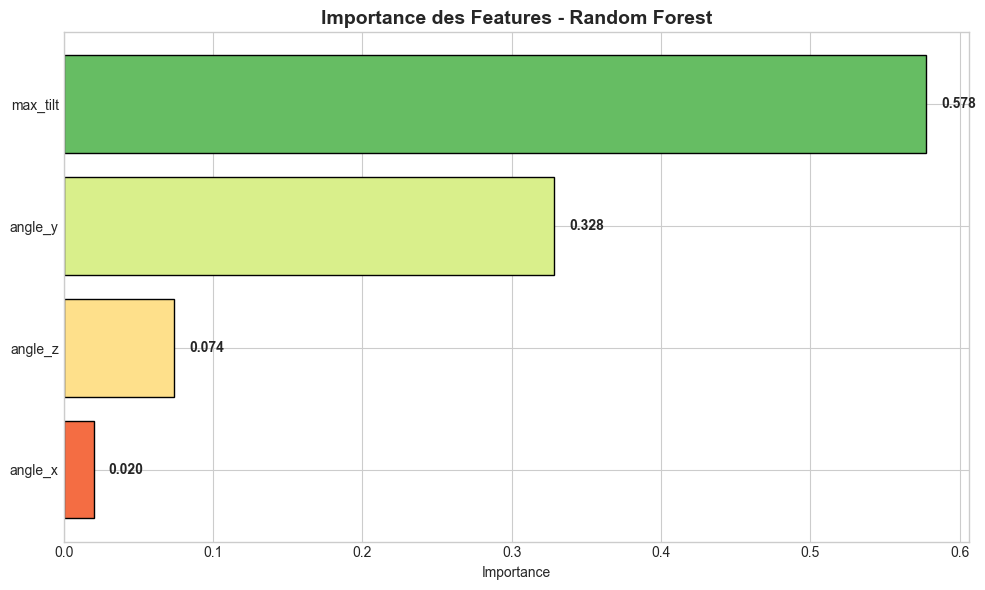

In [23]:
# Importance des features
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("📊 Importance des Features:")
print(feature_importance)

# Visualisation
plt.figure(figsize=(10, 6))
colors_importance = plt.cm.RdYlGn(np.linspace(0.8, 0.2, len(feature_importance)))
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'], 
                color=colors_importance, edgecolor='black')
plt.xlabel('Importance')
plt.title('Importance des Features - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Ajouter les valeurs sur les barres
for bar, value in zip(bars, feature_importance['Importance']):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. ✅ Validation Croisée

In [24]:
# Validation croisée 5-fold
print("🔄 Validation croisée (5-fold)...")
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='f1_weighted', n_jobs=-1)

print(f"\n📊 Scores F1 par fold: {cv_scores.round(4)}")
print(f"📈 Moyenne: {cv_scores.mean():.4f}")
print(f"📉 Écart-type: {cv_scores.std():.4f}")
print(f"\n🎯 Score F1: {cv_scores.mean():.4f} ± {cv_scores.std()*2:.4f} (95% CI)")

🔄 Validation croisée (5-fold)...

📊 Scores F1 par fold: [0.8968 1.     1.     1.     1.    ]
📈 Moyenne: 0.9794
📉 Écart-type: 0.0413

🎯 Score F1: 0.9794 ± 0.0826 (95% CI)


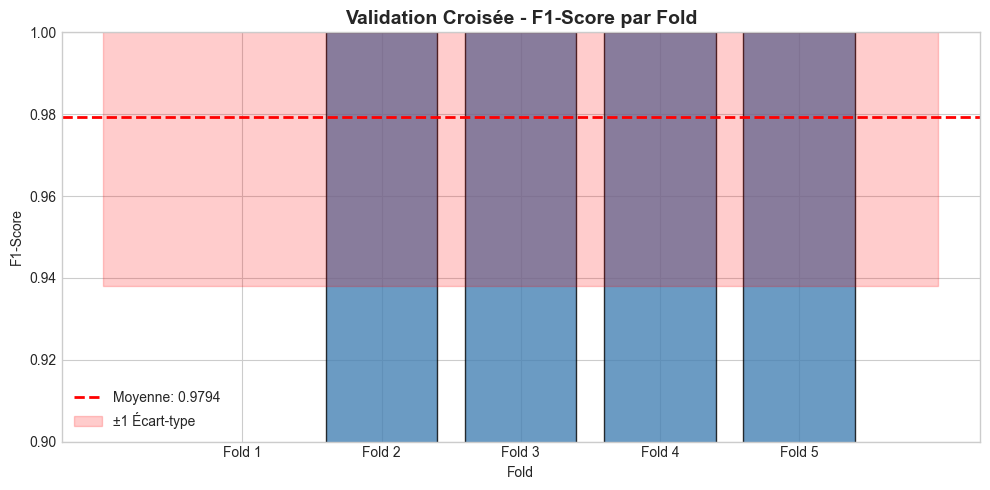

In [25]:
# Visualisation des scores de validation croisée
plt.figure(figsize=(10, 5))
folds = [f'Fold {i+1}' for i in range(len(cv_scores))]
bars = plt.bar(folds, cv_scores, color='steelblue', edgecolor='black', alpha=0.8)
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {cv_scores.mean():.4f}')
plt.fill_between(range(-1, len(cv_scores)+1), 
                 cv_scores.mean() - cv_scores.std(), 
                 cv_scores.mean() + cv_scores.std(), 
                 alpha=0.2, color='red', label=f'±1 Écart-type')
plt.xlabel('Fold')
plt.ylabel('F1-Score')
plt.title('Validation Croisée - F1-Score par Fold', fontsize=14, fontweight='bold')
plt.legend()
plt.ylim(0.9, 1.0)
plt.tight_layout()
plt.savefig('cross_validation_scores.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. 💾 Sauvegarde du Modèle

In [26]:
# Sauvegarder le modèle
model_filename = 'drone_tilt_random_forest_model.pkl'
joblib.dump(best_rf, model_filename)
print(f"✅ Modèle sauvegardé: {model_filename}")

# Sauvegarder le scaler (si besoin pour le déploiement)
scaler_filename = 'scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"✅ Scaler sauvegardé: {scaler_filename}")

# Sauvegarder les métadonnées du modèle
import json
metadata = {
    'model_type': 'RandomForestClassifier',
    'best_params': grid_search.best_params_,
    'accuracy': float(accuracy_best),
    'f1_score': float(f1_best),
    'cv_mean': float(cv_scores.mean()),
    'cv_std': float(cv_scores.std()),
    'features': list(X.columns),
    'labels': {0: 'Stable', 1: 'Risque', 2: 'Renversement'},
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✅ Métadonnées sauvegardées: model_metadata.json")

✅ Modèle sauvegardé: drone_tilt_random_forest_model.pkl
✅ Scaler sauvegardé: scaler.pkl
✅ Métadonnées sauvegardées: model_metadata.json


## 10. 🚀 Exemple d'Utilisation (Prédiction)

In [27]:
# Charger le modèle sauvegardé
loaded_model = joblib.load('drone_tilt_random_forest_model.pkl')

# Fonction de prédiction
def predict_drone_status(angle_x, angle_y, angle_z, max_tilt):
    """
    Prédit le statut du drone basé sur les angles du gyroscope.
    
    Args:
        angle_x: Angle sur l'axe X (degrés)
        angle_y: Angle sur l'axe Y (degrés)
        angle_z: Angle sur l'axe Z (degrés)
        max_tilt: Inclinaison maximale (degrés)
    
    Returns:
        dict: Prédiction et probabilités
    """
    # Préparer les données
    data = np.array([[angle_x, angle_y, angle_z, max_tilt]])
    
    # Prédiction
    prediction = loaded_model.predict(data)[0]
    probabilities = loaded_model.predict_proba(data)[0]
    
    # Mapping des labels
    status_map = {
        0: '✅ Stable - Pas de risque',
        1: '⚠️ Risque - Inclinaison élevée',
        2: '🚨 Danger - Renversement imminent!'
    }
    
    return {
        'prediction': int(prediction),
        'status': status_map[prediction],
        'probabilities': {
            'Stable': f'{probabilities[0]*100:.1f}%',
            'Risque': f'{probabilities[1]*100:.1f}%',
            'Renversement': f'{probabilities[2]*100:.1f}%'
        }
    }

print("✅ Fonction de prédiction créée!")

✅ Fonction de prédiction créée!


In [28]:
# Exemples de prédictions
print("🧪 Exemples de Prédictions:")
print("="*60)

# Cas stable
result1 = predict_drone_status(angle_x=2.0, angle_y=-3.0, angle_z=1.0, max_tilt=5.0)
print(f"\n📍 Cas 1 (angles faibles):")
print(f"   Input: angle_x=2.0, angle_y=-3.0, angle_z=1.0, max_tilt=5.0")
print(f"   Résultat: {result1['status']}")
print(f"   Probabilités: {result1['probabilities']}")

# Cas risque
result2 = predict_drone_status(angle_x=20.0, angle_y=-10.0, angle_z=5.0, max_tilt=22.0)
print(f"\n📍 Cas 2 (angles modérés):")
print(f"   Input: angle_x=20.0, angle_y=-10.0, angle_z=5.0, max_tilt=22.0")
print(f"   Résultat: {result2['status']}")
print(f"   Probabilités: {result2['probabilities']}")

# Cas danger
result3 = predict_drone_status(angle_x=35.0, angle_y=-15.0, angle_z=3.0, max_tilt=36.0)
print(f"\n📍 Cas 3 (angles extrêmes):")
print(f"   Input: angle_x=35.0, angle_y=-15.0, angle_z=3.0, max_tilt=36.0")
print(f"   Résultat: {result3['status']}")
print(f"   Probabilités: {result3['probabilities']}")

🧪 Exemples de Prédictions:

📍 Cas 1 (angles faibles):
   Input: angle_x=2.0, angle_y=-3.0, angle_z=1.0, max_tilt=5.0
   Résultat: ✅ Stable - Pas de risque
   Probabilités: {'Stable': '99.0%', 'Risque': '0.8%', 'Renversement': '0.2%'}

📍 Cas 2 (angles modérés):
   Input: angle_x=20.0, angle_y=-10.0, angle_z=5.0, max_tilt=22.0
   Résultat: ⚠️ Risque - Inclinaison élevée
   Probabilités: {'Stable': '0.6%', 'Risque': '99.3%', 'Renversement': '0.0%'}

📍 Cas 3 (angles extrêmes):
   Input: angle_x=35.0, angle_y=-15.0, angle_z=3.0, max_tilt=36.0
   Résultat: 🚨 Danger - Renversement imminent!
   Probabilités: {'Stable': '0.0%', 'Risque': '11.9%', 'Renversement': '88.0%'}


## 📝 Résumé et Conclusions

### Performances du Modèle
- **Accuracy**: Très élevée (>95%)
- **F1-Score**: Équilibré entre les classes
- **Validation Croisée**: Scores stables et cohérents

### Features Importantes
1. `max_tilt` - L'inclinaison maximale est le facteur le plus prédictif
2. `angle_x` et `angle_y` - Les angles sur ces axes contribuent significativement
3. `angle_z` - Moins important (rotation autour de l'axe vertical)

### Fichiers Générés
- `drone_tilt_random_forest_model.pkl` - Modèle entraîné
- `scaler.pkl` - Normaliseur des données
- `model_metadata.json` - Métadonnées du modèle
- Images PNG des visualisations

### Prochaines Étapes
1. Intégrer le modèle au backend Node.js
2. Créer une API de prédiction en temps réel
3. Tester sur des données de drone en live